In [3]:
import os
import pandas as pd
import surprise
import yaml

from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
# Clone the data repo (109 MiB as if 2019-11-17)
# Will error out if you already have it
# !echo "Cloning and backing up repo..."
# !git clone https://github.com/acmeism/RosettaCodeData && cp -R RosettaCodeData RosettaCodeData-backup

# !echo "Compressing..."
# !rm RosettaCodeData.zip
# !zip -rq -9 RosettaCodeData.zip RosettaCodeData

# !echo "Peeking into compressed files..."
# !unzip -lv RosettaCodeData.zip > RosettaCodeData.txt

# !echo "Done!"

In [5]:
chosen_tasks = pd.read_csv('special-tasks.txt', header=None, sep='\t')
chosen_tasks.columns=['url']

# Task selection: not so mathematical ones
with open('RosettaCodeData/Meta/Task.yaml') as task_names:
    names = pd.DataFrame(yaml.safe_load(task_names)).T
    names.loc[:, 'url'] = names.loc[:, 'url'].map(lambda url: f'https://rosettacode.org/wiki/{url}')
    
tasks = set(chosen_tasks.merge(names, how='inner')['path'])

In [6]:
languages = os.listdir(os.path.join('RosettaCodeData', 'Lang'))

comp_sizes = {}

with open('RosettaCodeData.txt') as f:
    with open('dupes.txt', 'w') as g:
        for line in f:
            stats = line.split()
            try:
                if len(stats) == 8 and stats[1] != 'Stored':
                    comp_size = int(stats[2])
                    path = stats[7].split('/')
                    task = path[2]
                    lang = path[3]

                    if (lang, task) in comp_sizes:
                        print(f'!rm {stats[7]}', file=g)
                        # Multiple implementations of same task and same language; 
                        # can't manually check which is right (too many)
                        # so we completely drop duplicates 
                        
                        # This is most important when dealing with the Rosetta Code dataset, 
                        # while the wiki format does not clarify alternative implementations
                        comp_sizes[(lang, task)] = None
                    elif task not in tasks:
                        comp_sizes[(lang, task)] = None
                    else:
                        comp_sizes[(lang, task)] = comp_size
            except ValueError:
                pass
            except IndexError:
                pass
            

In [7]:
len(comp_sizes)

94988

In [40]:
def get_path(*deeper):
    return os.path.join('RosettaCodeData', 'Task', *deeper)

# Plain file size of evaluation, instead of zipped size; kept for reference
def measure(task, lang):
    files = os.listdir(get_path(task, lang))
    if len(files) == 1:
        return os.stat(get_path(task, lang, files[0])).st_size
    else:
        raise KeyError(f'Duplicate files for task {task} lang {lang}')

# def measure(task, lang):
#     res = comp_sizes[(lang, task)]
#     if res:
#         return res
#     else:
#         raise KeyError(f'Duplicate files for task {task} lang {lang}')
    
# measure('24-game', 'Python')

In [41]:
measure('Greyscale-bars-Display', 'Python')

729

In [42]:
votes_list = []

for lang in languages:
    for task in tasks:
        try:
            votes_list.append([task, lang, measure(task, lang)])
        except KeyError:
            pass
        except FileNotFoundError:
            pass

In [43]:
votes = pd.DataFrame(votes_list, columns=['task', 'lang', 'measure']).replace([pd.np.inf, -pd.np.inf], pd.np.nan).dropna()
votes['measure'] = pd.np.log(votes['measure']+1)
votes['measure'].describe()

count    7766.000000
mean        5.757733
std         1.302263
min         0.000000
25%         4.882802
50%         5.783825
75%         6.639876
max         9.995200
Name: measure, dtype: float64

In [44]:
# Get an idea of the RMSE and MAE
reader = surprise.Reader(rating_scale=(votes['measure'].min(), votes['measure'].max()))
dataset = surprise.Dataset.load_from_df(votes, reader)
algo = surprise.SVDpp()
surprise.model_selection.cross_validate(algo, dataset, cv=2)

{'test_rmse': array([0.76906677, 0.78847251]),
 'test_mae': array([0.58661586, 0.59717175]),
 'fit_time': (1.9821767807006836, 2.2045161724090576),
 'test_time': (0.191849946975708, 0.2016744613647461)}

In [45]:
full_set = dataset.build_full_trainset()
algo.fit(full_set)

In [46]:
missing_set = full_set.build_anti_testset()
preds = algo.test(missing_set)
assert len(preds) > 0
est_votes = pd.DataFrame(preds).loc[:, ['uid', 'iid', 'est']]
est_votes.columns = ['task', 'lang', 'measure']

In [47]:
all_votes = pd.concat([votes, est_votes]).reset_index(drop=True).set_index(['task', 'lang'])
all_votes.sum(level=1).sort_values('measure')

,measure
lang,
Burlesque,711.217501
K,728.364542
Wart,730.948324
Gnuplot,731.087152
Mathematica,732.288586
...,...
COBOL,1026.743148
LLVM,1042.581852
REXX,1047.504791


# Most verbose languages

In [48]:
pd.np.exp(all_votes).mean(level=1).sort_values('measure', ascending=False).head(10)

,measure
lang,
ARM-Assembly,8191.397456
360-Assembly,2908.322219
REXX,2200.823137
COBOL,1994.216574
LLVM,1950.484815
ALGOL-W,1803.802797
MIPS-Assembly,1721.492599
NetRexx,1627.770084
Simula,1566.650391


# Tersest languages

In [49]:
tersest = pd.np.exp(all_votes).mean(level=1).sort_values('measure')
tersest.to_csv('tersest-unzipped.csv')
tersest.head(10)

,measure
lang,
Burlesque,227.470759
Wart,256.508851
K,261.634524
Gnuplot,262.049625
Oforth,271.478314
Befunge,284.436212
GUISS,284.856619
APL,291.859609
FALSE,295.873795


In [50]:
lengths = tersest.reset_index()
pops = pd.read_csv('pop-index.csv')
paired = lengths.merge(pops, how='inner')
paired.loc[:, 'Popularity'] = pd.np.log(paired.loc[:, 'Popularity'])
df = paired.set_index('lang').loc[:, ['measure', 'Popularity']]
df.columns=['Code length', 'Popularity (Tiobe, Github, Rosetta)']

In [51]:
# Sparsity of data
len(votes) / len(all_votes)

0.13618827160493827

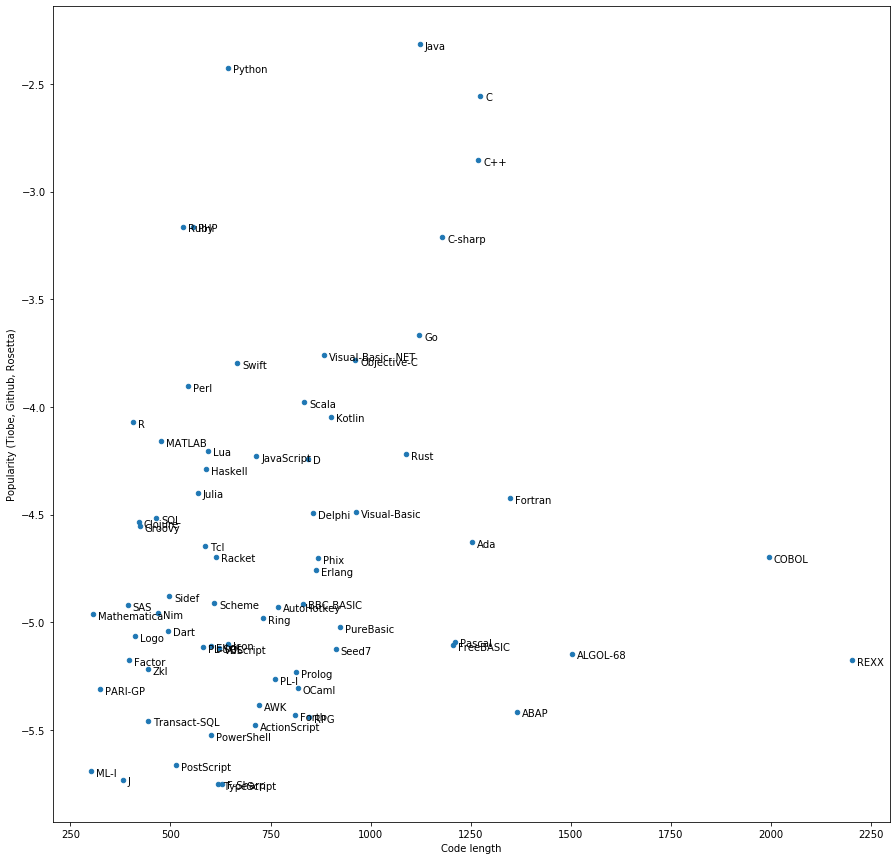

In [52]:
fig, ax = plt.subplots()
df.plot('Code length', 'Popularity (Tiobe, Github, Rosetta)', kind='scatter', ax=ax, figsize=(15, 15))

for k, v in df.iterrows():
    ax.annotate(k, v, xytext=(5,-5), textcoords='offset points')

# Hardest problems

In [53]:
pd.np.exp(all_votes).mean(level=0).sort_values('measure', ascending=False).head(20)

,measure
task,
Stable-marriage-problem,3654.492272
Zebra-puzzle,3132.066954
Arithmetic-evaluation,2335.679698
Maze-solving,2225.958183
Sudoku,2197.956395
Chat-server,2113.688979
Update-a-configuration-file,2049.354877
Topological-sort,1865.331943
Solve-a-Hidato-puzzle,1765.407956


In [76]:
compare = pd.merge(pd.read_csv('tersest-zipped.csv'), pd.read_csv('tersest-unzipped.csv'), on='lang').set_index('lang')
compare['compression-ratio'] = compare['measure_y'] / compare['measure_x']
compare.sort_values('compression-ratio').to_csv('tersest-compare.csv')